In [68]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage.util import random_noise
from tensorflow.keras.layers import Layer, Conv2D, Add, ReLU, Concatenate, GlobalAveragePooling2D, Multiply, Input, Lambda,  MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from keras.models import load_model
from tensorflow.keras.saving import register_keras_serializable


In [69]:

def preprocess(sample, img_size):
    """Preprocessa le immagini: ridimensionamento e normalizzazione."""
    image = tf.image.resize(sample['image'], img_size) / 255.0  # Normalizza in [0,1]
    label = sample['label']  # Estrai l'etichetta
    return image, label

def load_dataset(split='train', img_size=(256,256), batch_size=16):
    """
    Carica il dataset Oxford-IIIT Pet da tfds e applica il preprocessamento.
    Ritorna un dataset in batch.
    """
    dataset = tfds.load('oxford_iiit_pet', split=split, as_supervised=False)  # as_supervised=False per mantenere dict
    dataset = dataset.map(lambda sample: preprocess(sample, img_size))  # Preprocessing
    dataset = dataset.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)  # Ottimizza il caricamento
    return dataset



In [70]:
# Parametri
img_size = (224, 224)
batch_size = 20
noise_factor = np.random.uniform(0.1, 0.9)
epochs = 50

# Caricamento dataset
train_ds = load_dataset(split='train', img_size=img_size, batch_size=batch_size)
test_ds  = load_dataset(split='test', img_size=img_size, batch_size=batch_size)

In [71]:
def add_noise(x, noise_factor=0.1):
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=1.0)
    x_noisy = x + noise_factor * noise
    x_noisy = tf.clip_by_value(x_noisy, 0.0, 1.0)
    return x_noisy

In [72]:
def add_noise_2(x):
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=1.0)

    # Generiamo un array di fattori di scala con la stessa lunghezza del batch
    batch_size = tf.shape(x)[0]
    scale_factors = tf.random.uniform(shape=(batch_size, 1, 1, 1), minval=0.1, maxval=0.9)

    x_noisy = x + scale_factors * noise
    x_noisy = tf.clip_by_value(x_noisy, 0.0, 1.0)
    return x_noisy

In [73]:
def add_random_noise(tensor_image):
    """
    Aggiunge rumore casuale a un'immagine convertendo il tensore in NumPy.
    """
    numpy_image = tensor_image.numpy()

    # Genera un noise_factor casuale tra 0.1 e 0.9
    noise_factor = np.random.uniform(0.1, 0.9)

    # Scegli il tipo di rumore
    noise_types = ['gaussian', 'salt', 'pepper', 's&p', 'speckle', 'poisson']
    noise_type = random.choice(noise_types)

    # Applica il rumore
    noisy_img = random_noise(numpy_image, mode=noise_type, clip=True) * (1 - noise_factor) + noise_factor * np.random.rand(*numpy_image.shape)

    # Converti di nuovo in tf.Tensor
    return tf.convert_to_tensor(noisy_img, dtype=tf.float32)

# Wrapper compatibile con tf.data.Dataset.map()
def add_random_noise_tf(tensor_image, label):
    noisy_image = tf.py_function(func=add_random_noise, inp=[tensor_image], Tout=tf.float32)

    # Impostiamo la forma esplicitamente per evitare problemi con tf.data
    noisy_image.set_shape(tensor_image.shape)

    return noisy_image  # Restituiamo solo l'immagine rumorosa

In [74]:

train_ds_noisy = train_ds.map(lambda x, label: (add_random_noise_tf(x, label), x))
test_ds_noisy  = test_ds.map(lambda x, label: (add_random_noise_tf(x, label), x))  # Aggiungiamo anche le immagini

#train_ds_noisy = train_ds.map(add_random_noise_tf)
#test_ds_noisy  = test_ds.map(add_random_noise_tf)

In [75]:
def plot_side_by_side(x_noisy, x_original, n=10):
    """
    Visualizza n coppie di immagini affiancando l'immagine rumorosa e quella originale per immagini a colori.
    """
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Immagine rumorosa
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_noisy[i])
        plt.title("Rumorosa")
        plt.axis('off')

        # Immagine originale
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(x_original[i])
        plt.title("Originale")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

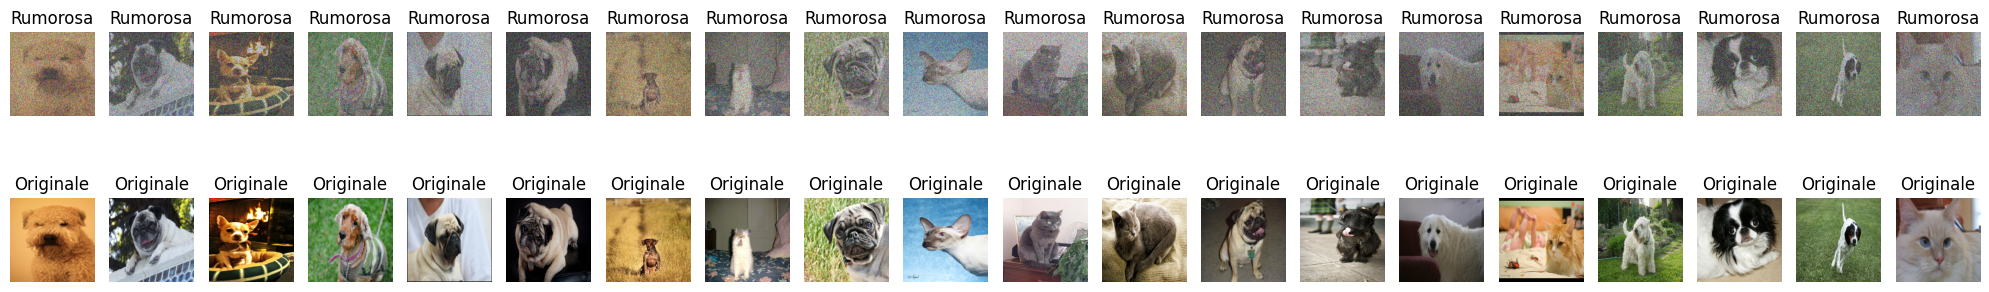

In [76]:
# Prendi un batch dal dataset (ad esempio, il primo batch)
batch = next(iter(test_ds_noisy))
x_noisy_batch, x_original_batch = batch

# Converti i tensori in array NumPy
x_noisy_np = x_noisy_batch.numpy()
x_original_np = x_original_batch.numpy()

# Usa la funzione plot_side_by_side per visualizzare n immagini
plot_side_by_side(x_noisy_np, x_original_np, n=batch_size)


Creazione modello

In [77]:
# MeanShift: sottrae (o aggiunge) la media RGB
@register_keras_serializable("MeanShift")
class MeanShift(Layer):
    def __init__(self, rgb_mean, sign=-1, **kwargs):
        """
        rgb_mean: tupla con la media dei canali R, G, B.
        sign: -1 per sottrarre la media, 1 per aggiungerla.
        """
        super(MeanShift, self).__init__(**kwargs)
        self.rgb_mean = tf.constant(rgb_mean, dtype=tf.float32)
        self.sign = sign

    def call(self, x):
        # x è atteso in formato (batch, altezza, larghezza, 3)
        # Sfruttiamo Lambda per eseguire l'operazione per ogni elemento
        # Nota: non stiamo scalando per std in questo esempio
        return x + self.sign * self.rgb_mean

# BasicBlock: Conv2D seguita da attivazione ReLU
@register_keras_serializable("BasicBlock")
class BasicBlock(Layer):
    def __init__(self, out_channels, kernel_size=3, stride=1, use_bias=False, **kwargs):
        super(BasicBlock, self).__init__(**kwargs)
        self.conv = Conv2D(out_channels, kernel_size, strides=stride,
                           padding='same', use_bias=use_bias)
        self.relu = ReLU()

    def call(self, x):
        return self.relu(self.conv(x))

# ResidualBlock: due convoluzioni con skip connection(come lavora cuda con 2 thread -> 2 filtri applicati e poi si uniscono i risultati)
@register_keras_serializable("ResidualBlock")
class ResidualBlock(Layer):
    def __init__(self, out_channels, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = Conv2D(out_channels, 3, strides=1, padding='same')
        self.relu = ReLU()
        self.conv2 = Conv2D(out_channels, 3, strides=1, padding='same')

    def call(self, x):
        residual = self.conv1(x)
        residual = self.relu(residual)
        residual = self.conv2(residual)
        out = Add()([x, residual])
        return ReLU()(out)

# EResidualBlock: versione estesa con convoluzioni a gruppi
@register_keras_serializable("EResidualBlock")
class EResidualBlock(Layer):
    def __init__(self, out_channels, groups=1, **kwargs):
        super(EResidualBlock, self).__init__(**kwargs)
        self.conv1 = Conv2D(out_channels, 3, strides=1, padding='same', groups=groups)
        self.relu = ReLU()
        self.conv2 = Conv2D(out_channels, 3, strides=1, padding='same', groups=groups)
        self.conv3 = Conv2D(out_channels, 1, strides=1, padding='valid')

    def call(self, x):
        residual = self.conv1(x)
        residual = self.relu(residual)
        residual = self.conv2(residual)
        residual = self.relu(residual)
        residual = self.conv3(residual)
        out = Add()([x, residual])
        return ReLU()(out)

# Merge_Run_dual: due rami convoluzionali con dilatazioni diverse, poi fusione e skip connection
@register_keras_serializable("MergeRunDual")
class MergeRunDual(Layer):
    def __init__(self, out_channels, **kwargs):
        super(MergeRunDual, self).__init__(**kwargs)
        # Primo ramo
        self.conv1a = Conv2D(out_channels, 3, strides=1, padding='same')
        self.relu1a = ReLU()
        self.conv1b = Conv2D(out_channels, 3, strides=1, padding='same', dilation_rate=2)
        self.relu1b = ReLU()
        # Secondo ramo
        self.conv2a = Conv2D(out_channels, 3, strides=1, padding='same', dilation_rate=3)
        self.relu2a = ReLU()
        self.conv2b = Conv2D(out_channels, 3, strides=1, padding='same', dilation_rate=4)
        self.relu2b = ReLU()
        # Gogeta
        self.conv3 = Conv2D(out_channels, 3, strides=1, padding='same')
        self.relu3 = ReLU()

    def call(self, x):
        branch1 = self.relu1a(self.conv1a(x))
        branch1 = self.relu1b(self.conv1b(branch1))

        branch2 = self.relu2a(self.conv2a(x))
        branch2 = self.relu2b(self.conv2b(branch2))

        merged = Concatenate()([branch1, branch2])
        merged = self.relu3(self.conv3(merged))
        return Add()([merged, x])

# CALayer: Channel Attention Layer
@register_keras_serializable("CALayer")
class CALayer(Layer):
    def __init__(self, channel, reduction=16, **kwargs):
        super(CALayer, self).__init__(**kwargs)
        self.channel = channel
        self.reduction = reduction
        self.conv1 = Conv2D(channel // reduction, 1, strides=1, padding='same')
        self.relu = ReLU()
        self.conv2 = Conv2D(channel, 1, strides=1, padding='same', activation='sigmoid') #sigmoid: risultato tra 0 e 1

    def call(self, x):
        # Calcolo della media globale per canale
        y = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
        y = self.relu(self.conv1(y))
        y = self.conv2(y)
        return Multiply()([x, y])

# Block: combinazione di MergeRunDual, ResidualBlock, EResidualBlock e CALayer
@register_keras_serializable("Block")
class Block(Layer):
    def __init__(self, out_channels, **kwargs):
        super(Block, self).__init__(**kwargs)
        self.merge_run_dual = MergeRunDual(out_channels)
        self.residual_block = ResidualBlock(out_channels)
        self.e_residual_block = EResidualBlock(out_channels)
        self.ca = CALayer(out_channels)

    def call(self, x):
        r1 = self.merge_run_dual(x)
        r2 = self.residual_block(r1)
        r3 = self.e_residual_block(r2)
        out = self.ca(r3)
        return out

# RIDNET: il modello final
@register_keras_serializable("RIDNET")
def RIDNET(n_feats=64, rgb_range=1.0):
    """
    n_feats: numero di feature channels usate all'interno del modello.
    rgb_range: scala dei valori RGB (ad es. 1.0 se l'input è normalizzato [0,1]).
    """
    rgb_mean = (0.4488, 0.4371, 0.4040)

    input_layer = Input(shape=(None, None, 3))

    # Sottosottrai la media (MeanShift con sign=-1)
    sub_mean = MeanShift(rgb_mean, sign=-1)
    x = sub_mean(input_layer)

    # Testa: BasicBlock (conv + ReLU)
    head = Conv2D(n_feats, 3, strides=1, padding='same', activation='relu')(x)

    # Serie di blocchi
    b1 = Block(n_feats)(head)
    b2 = Block(n_feats)(b1)
    b3 = Block(n_feats)(b2)
    b4 = Block(n_feats)(b3)

    # Coda: convoluzione finale per ottenere 3 canali
    tail = Conv2D(3, 3, strides=1, padding='same')(b4)

    # Aggiungi la media (MeanShift con sign=+1)
    add_mean = MeanShift(rgb_mean, sign=1)
    res = add_mean(tail)

    # Connessione residua a livello di immagine: somma con l'input originale
    output = Add()([res, input_layer])

    model = Model(inputs=input_layer, outputs=output)
    return model

In [78]:
def plot_denoising_results(x_test_noisy, decoded_imgs, x_test, n=10):
    """
    Visualizza n immagini rumorose, le rispettive immagini denoised e quelle originali.
    """
    plt.figure(figsize=(20, 4))
    n = 10
    for i in range(n):
        # Immagine rumorosa
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test_noisy[i])
        plt.title("Rumorosa")
        plt.axis('off')
        # Immagine denoised
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.title("Denoised")
        plt.axis('off')
        # Immagine originale
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(x_test[i])
        plt.title("Originale")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [79]:
def build_autoencoder(input_shape):
    """
    Costruisce un autoencoder convoluzionale per immagini a colori.
    Parametri:
      input_shape: forma dell'immagine in input (es. (32,32,3))
    Ritorna:
      autoencoder: modello compilato
    """
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3,3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2,2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    decoded = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

def train_autoencoder(autoencoder, x_train_noisy, x_train, x_test_noisy, x_test, epochs=50, batch_size=128):
    """
    Addestra l'autoencoder utilizzando le immagini rumorose come input e quelle originali come target.
    """
    history = autoencoder.fit(x_train_noisy, x_train,
                              epochs=epochs,
                              batch_size=batch_size,
                              shuffle=True,
                              validation_data=(x_test_noisy, x_test))
    return history

In [80]:
autoencoder = build_autoencoder(input_shape=(img_size[0], img_size[1], 3))
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_55 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_56 (Conv2D)                   │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_57 (Conv2D)                   │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_58 (Conv2D)                   │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 224, 224, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_59 (Conv2D)                   │ (None, 224, 224, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 114,307 (446.51 KB)

 Trainable params: 114,307 (446.51 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
autoencoder.fit(train_ds_noisy,
                validation_data=test_ds_noisy,
                epochs=10)

Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 91s 426ms/step - loss: 0.6749 - val_loss: 0.5753
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 74s 389ms/step - loss: 0.5966 - val_loss: 0.5617
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 70s 369ms/step - loss: 0.5677 - val_loss: 0.5580
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 74s 387ms/step - loss: 0.5560 - val_loss: 0.5509
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 84s 406ms/step - loss: 0.5585 - val_loss: 0.5507
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 73s 388ms/step - loss: 0.5607 - val_loss: 0.5610
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 71s 373ms/step - loss: 0.5556 - val_loss: 0.5594
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 73s 388ms/step - loss: 0.5539 - val_loss: 0.5480
Epoch 9/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 67s 352ms/step - loss: 0.5542 - val_loss: 0.5418
Epoch 10/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 87s 376ms/step - loss: 0.5494 - val_loss: 0.5507


In [84]:
decoded_imgs = autoencoder.predict(x_noisy_np)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


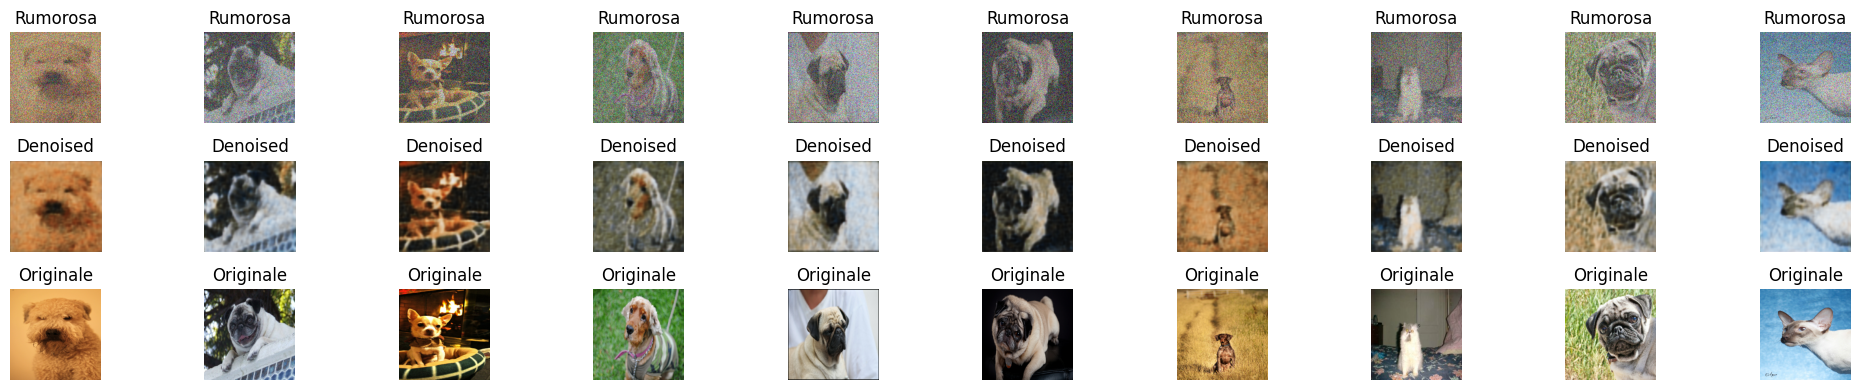

In [85]:
plot_denoising_results(x_noisy_np, decoded_imgs, x_original_np, n=10)

In [86]:
autoencoder.save('new_autoencoder.keras')